# EEG-preproccesing 
This is where all the preprocessing relevant to our exam project is collected. It contains:
1. Excluding bad channels
2. Common average reference
3. Filtering
4. Artefact rejection
5. Epoching
6. Downsampling

All further code for the analysis (actually finding the amplitudes of specific ERPs, visualising, etc. is not found in this notebook. 

## Creating the ENV and setting up the kernel
This project uses a jupyter kernel and the ENV has the following requirements:
* ipykernel 
* matplotlib==3.7.3
* mne[data]
* ipywidgets
* pandas

First the ENV is created with these requirements:

In [2]:
!bash ./setup_env.sh

./setup_env.sh: line 7: python: command not found
./setup_env.sh: line 10: /Users/katharina/Desktop/UNI/4. semester/EXAMS/NEURO/env/bin/activate: No such file or directory
./setup_env.sh: line 13: python: command not found
Done!


Now the right Kernel (called env) is activated, and the packages required are imported

In [1]:
!bash ./env_to_ipynb_kernel.sh

Installed kernelspec env in /Users/katharina/Library/Jupyter/kernels/env


In [2]:
import mne
import os
import matplotlib
import numpy as np
import glob

!pip install pandas
import pandas as pd
!pip install scikit-learn

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 4.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 3.4 MB/s eta 0:00:00a 0:00:01


## Loading in the data
We have data from two participants. 

In [6]:
# Load the data from first participant
path = 'raw_data/Group12_own.vhdr'
raw1 = mne.io.read_raw_brainvision(path, preload=True, eog = ('HEOG','VEOG'), misc = ['41'])

raw1.load_data()

path = 'raw_data/group12b_own.vhdr'
raw2 = mne.io.read_raw_brainvision(path, preload=True, eog = ('HEOG','VEOG'), misc = ['41'])

raw2.load_data()

Extracting parameters from raw_data/Group12_own.vhdr...
Setting channel info structure...
Reading 0 ... 523239  =      0.000 ...   523.239 secs...
Extracting parameters from raw_data/group12b_own.vhdr...
Setting channel info structure...
Reading 0 ... 547379  =      0.000 ...   547.379 secs...


/var/folders/hq/09bb9nmj3bs24myvqjb9lcxr0000gn/T/ipykernel_3304/1837473326.py:3: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw1 = mne.io.read_raw_brainvision(path, preload=True, eog = ('HEOG','VEOG'), misc = ['41'])
/var/folders/hq/09bb9nmj3bs24myvqjb9lcxr0000gn/T/ipykernel_3304/1837473326.py:8: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw2 = mne.io.read_raw_brainvision(path, preload=True, eog = ('HEOG','VEOG'), misc = ['41'])


Measurement date,"February 29, 2024 14:25:14 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"30 EEG, 2 EOG, 1 misc"
Bad channels,None
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,1000.00 Hz


Now we specify the layout of the cap, namely the placements of sensors in accordance to standard 1020

In [7]:
# Specify the channel locations
montage = mne.channels.make_standard_montage('standard_1020') 
raw1.set_montage(montage, verbose=False)
# Redefine the reference to a common average
raw1.set_eeg_reference('average', projection=False, verbose=False)

Measurement date,"February 29, 2024 14:26:11 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,"30 EEG, 2 EOG, 1 misc"
Bad channels,None
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,1000.00 Hz


Using matplotlib as 2D backend.


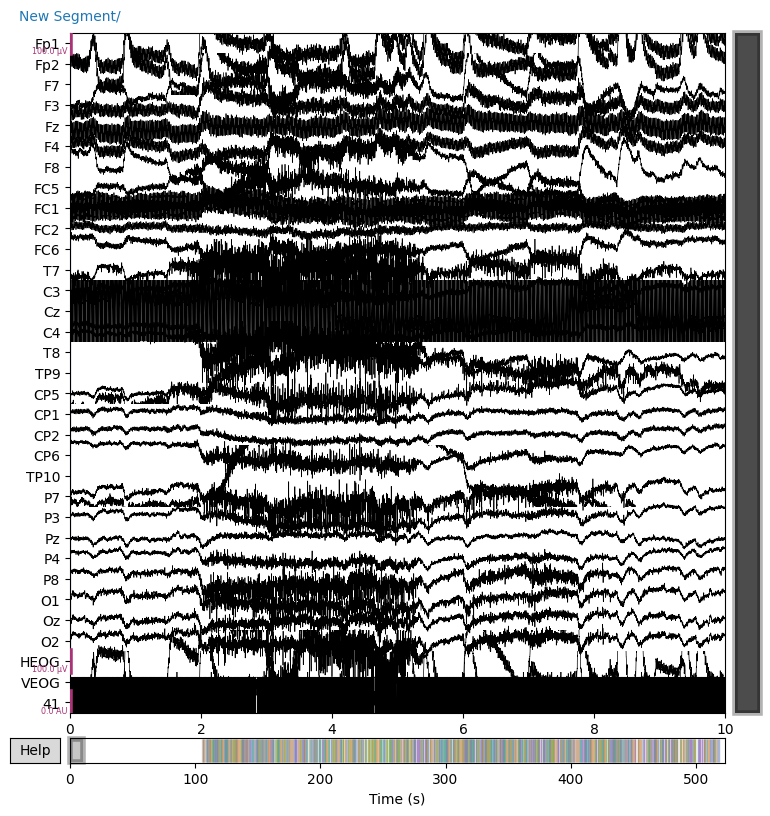

In [4]:
# Plot the data
raw1.plot(n_channels=33, scalings=50e-6);

From inspecting the plot we are able to exclude the bad channels.
Channel 41 is a misc sensor attached to the diode.

In [8]:
raw1.info["bads"] = ["Cz", "FC1", "41", "Fz"]

Using matplotlib as 2D backend.


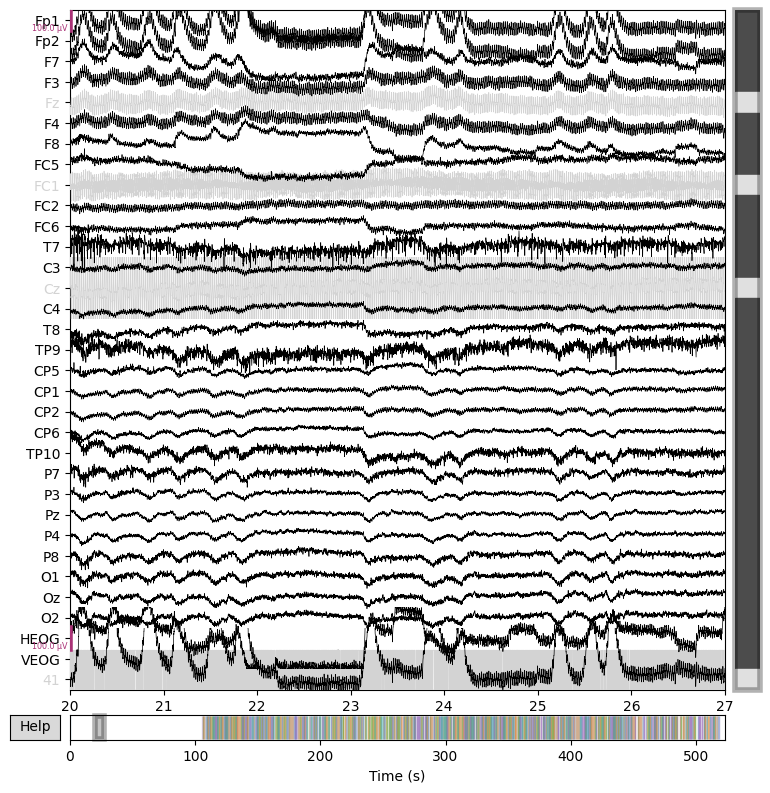

TypeError: Figure.pick() got an unexpected keyword argument 'exclude'

In [9]:
# Plot again after removing bad channels
raw1.plot(n_channels=33, scalings=50e-6, duration = 7, start = 20).pick(exclude="bads");

Now we filter the data with a band-pass filter from 0.1 - 30 Hz according to the default EEG band pass filtering for ERP studies: https://neuraldatascience.io/7-eeg/erp_filtering.html

In [10]:
# Filter the data
raw1.filter(l_freq = 0.1, h_freq = 30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Measurement date,"February 29, 2024 14:26:11 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,"27 EEG, 2 EOG"
Bad channels,"Cz, FC1, 41, Fz"
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


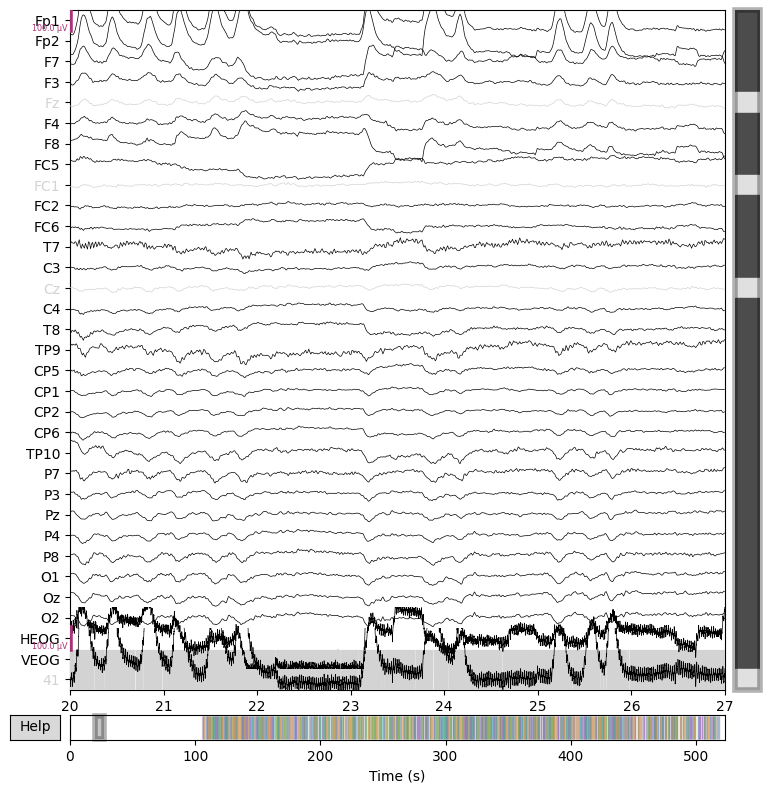

In [11]:
# Plot again to check
raw1.plot(n_channels=33, scalings=50e-6, duration = 7, start = 20);

We use ICA to figure out which channels to keep

Fitting ICA to data using 27 channels (please be patient, this may take a while)
Selecting by explained variance: 7 components
Fitting ICA took 2.2s.


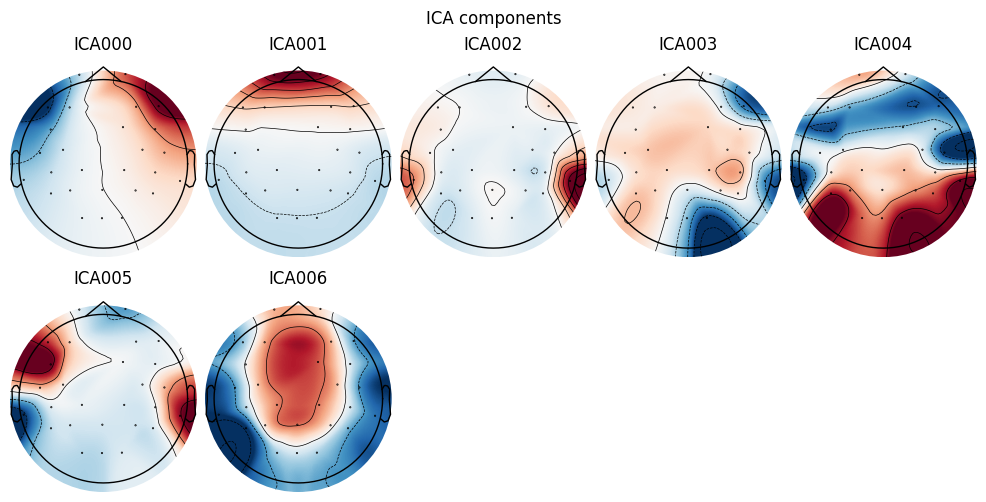

Creating RawArray with float64 data, n_channels=9, n_times=523240
    Range : 0 ... 523239 =      0.000 ...   523.239 secs
Ready.


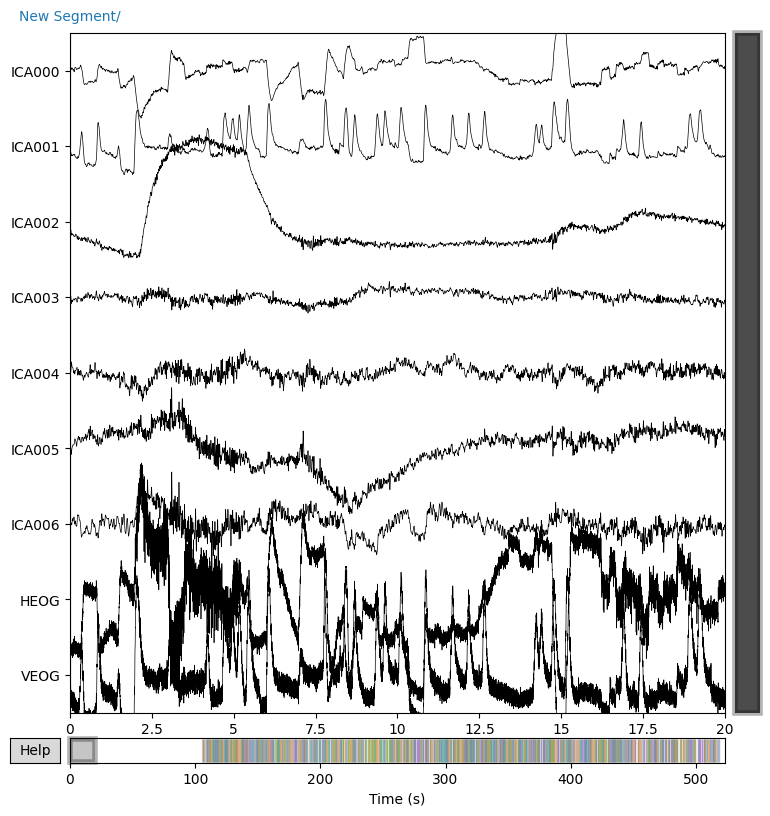

Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 2 ICA components
    Projecting back using 27 PCA components


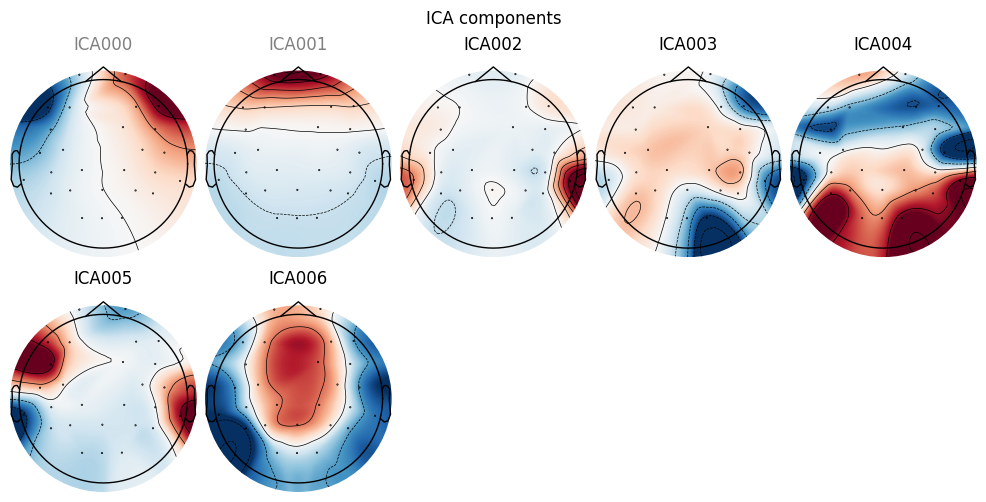

Creating RawArray with float64 data, n_channels=9, n_times=523240
    Range : 0 ... 523239 =      0.000 ...   523.239 secs
Ready.


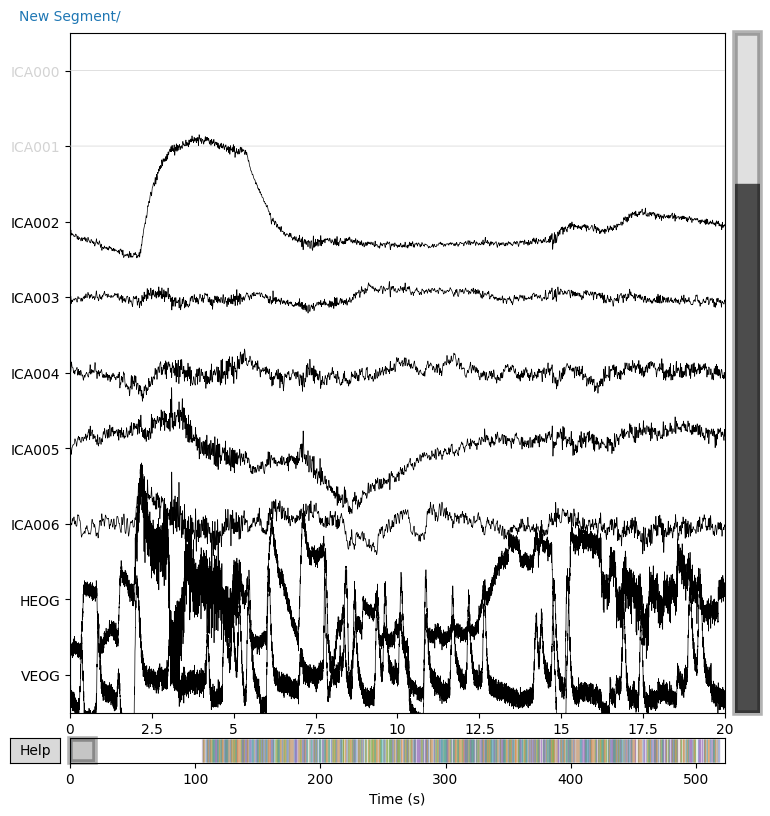

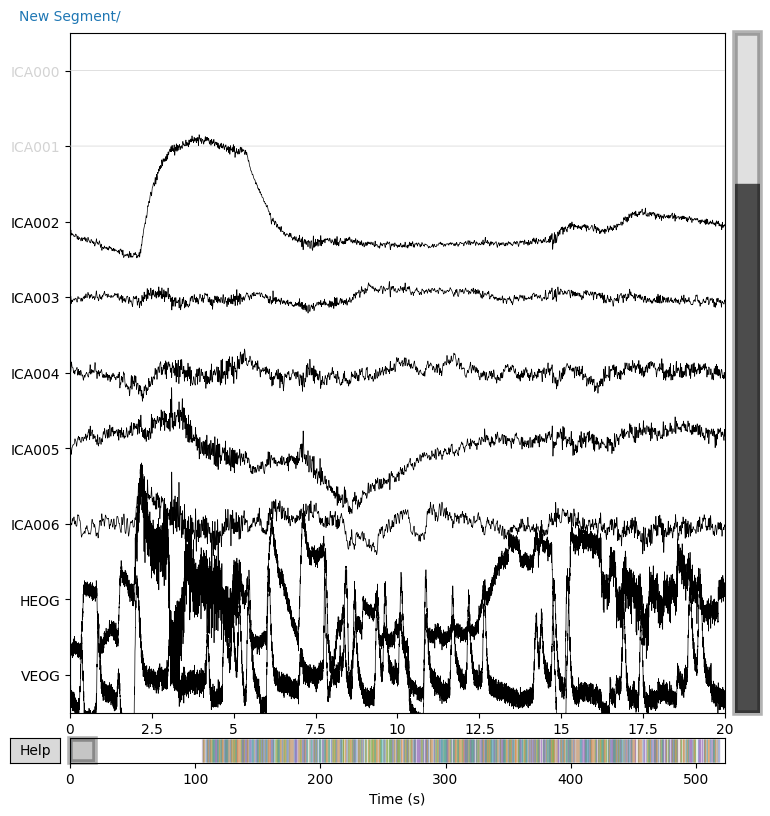

In [13]:
import sklearn
ica = mne.preprocessing.ICA(n_components=0.95, max_iter=800, random_state=7)

ica.fit(raw1)
ica.plot_components();
ica.plot_sources(raw1)
# excluding the eyes
ica.exclude = [0, 1]
ica.apply(raw1)

ica.plot_components()
ica.plot_sources(raw1)